In [8]:
import requests
from bs4 import BeautifulSoup
!pip install pycountry
import pycountry
import pandas as pd
import numpy as np
import json

You are using pip version 18.1, however version 20.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import matplotlib.pyplot as plt
from matplotlib import *
import seaborn as sns

In [3]:
!pip install matplotlib-venn

  Running setup.py bdist_wheel for matplotlib-venn ... done
  Stored in directory: /home/ffff/.cache/pip/wheels/c5/9c/ac/77b0c9151c4c264bec6ba18120d73bb24df5b4c1f09c17a41c
Successfully built matplotlib-venn
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/matplotlib_venn'
Consider using the `--user` option or check the permissions.

You are using pip version 18.1, however version 20.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install upsetplot

  Running setup.py bdist_wheel for upsetplot ... done
  Stored in directory: /home/ffff/.cache/pip/wheels/58/d7/bc/1b009e77db9e3d336873654b2185c30e4f9365c1063e8d745c
Successfully built upsetplot
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.6/dist-packages/upsetplot'
Consider using the `--user` option or check the permissions.

You are using pip version 18.1, however version 20.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Popularity-weighted blocking metric.

Our goal here is to produce a *directed* measure of country-to-country website blocking.

To illustrate our point,
here's a thought experiment: if a Norwegian goes to Indonesia, would they
actually notice that anything is blocked? If Indonesia blocks mostly Indonesian-language content, perhaps not. What if an American goes to China? Since China blocks most popular US websites, they probably will!

We measure this X-to-Y country-to-country comparison here. Our initial goal, upon starting, is to suss out international conflict points.

We'll do this measurement by finding the most *popular* websites in each country, according to Alexa.
Then, for each country, we see which other countries block those popular sites. The intuition here is that blocking Wikipedia is a bigger deal than blocking some tiny political website, since the former is more popular (i.e., widely-visited) than the latter.


## Website blocking data
You'll need to [download iclab-clean-fortiguard.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48).

Alternatively, if you want to produce this file yourself (i.e., to replicate our work), just run `bloging-pattern-similarity-metric.ipynb` in this repository.


In [7]:
iclabClean1 = pd.read_csv('../data/iclab_cleaned_data/iclab-cleaned-fortiguard.csv')

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Alexa data

In [ ]:
def TopSites(country_code):
  
  """
  Finds the top sites in a given country 
  Parameter:
      country_code - country whose top sites we are finding based on Alexa ratings
  Returns:
      Set of Top Websites in the country 
  """

  #Scraping Top Sites list from Alexa for country 
  url = "https://www.alexa.com/topsites/countries/" + country_code
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  div = soup.find_all('div', class_='td DescriptionCell')

  CC_top_list = []
  for link in div:
    name = link.find('a')
    CC_top_list.append((name.get_text('siteinfo')).lower())
  CC_top_set = set(CC_top_list) #Top sites in country 

  return CC_top_set

## 4.2 Scraping from Alexa

-- Top Visited = Top 50 websites in a country as per latest Alexa rankings
https://www.alexa.com/topsites/countries




### Functions

BlockedSites - Gives the set of websites blocked in a country

TopSites - Gives the set of top visited websites in a country

BlockedTopSites - Gives the top websites in country X which are blocked in country Y

topBlockSimilarity - Produces the new similarity metric

**find_similarity** - User Friendly Demo Function which will find directed similarity from countryX -> countryY , the edge symmetry and the average similarity between countries X&Y


In [ ]:
def BlockedSites(country_code):
  
  """
  Finds list of unique Blocked websites in a country
  Parameter:
        Country Code
  Returns:
        Set of Blocked Websites in the Country
  """

  # Country Specific blocked sites list
  CC_blocked_list = iclabClean1[(iclabClean1['country']==country_code)&(iclabClean1['censored_updated']==True)]['site'].tolist()
  CC_blocked_set = set(CC_blocked_list) # set of blocked sites in the country

  return CC_blocked_set

In [ ]:
def BlockedTopSites(TopSitesCountryX, BlockedSitesCountryY):

  """
  Finds the top sites from country X which are blocked in country Y.

  If you were to go from countryX to countryY, how much similar would you find the destination countryY to be similar to your source countryX.

  Parameters:
      TopSites_CountryX -  Top websites list from Country X we are finding
      BlockedSites_CountryY - List of websites blocked in country Y 
  Returns:
      Set of top sites from Country X which are blocked in Country Y
  """
  
  #Finding top sites from CountryX which are blocked in CountryY 
  X2Y = BlockedSitesCountryY.intersection(TopSitesCountryX) 
  if len(BlockedSitesCountryY)!=0:
    return X2Y
  else:
    return 0

In [ ]:
def topBlockSimilarity (X2YBlocking, Y2XBlocking, NTS =50):
  
  """
  Calculates the similarity metric based on top websites from a CountryX blocked in CountryY and vice-versa

  Working Formulae Explanation:
        If CountryX AND CountryY both block N (equal number of) Top websites of each other, their similarity is 1.
        If CountryX blocks N Top Websites of CountryY BUT CountryY blocks 0 Top Websites of CountryX, or vice-versa, their similarity is 0.
        If CountryX blocks N Top Websites of CountryY AND CountryY blocks M Top Websites of CountryX and M<N , their similarity is M/N.
        If CountryX blocks N Top Websites of CountryY AND CountryY blocks M Top Websites of CountryX and M>N , their similarity is N/M.
        Having a ratio ensures that the relative distance in their websites blocked is considered and not absolute numbers.
        For e.g. if X blocks 1 Top Websites of CountryY and Y blocks 41 Top Websites of CountryX, the absolute difference in the number of sites they are blocking is 40/
        /which should be different from a case wherein X blocks 160 Top Websites of CountryY and Y blocks 200, with absolute difference here also being 40 but the relative/
        /impact being different

  Parameters:
        X2YBlocking - Set of top sites from Country X which are blocked in Country Y
        Y2XBlocking - Set of top sites from Country Y which are blocked in Country X
        NTS(int) : Number of Top Sites being considered. The default value is 50 based on the number of results Alexa returns in a single page.

  Returns:
        Similarity Metrics (float) for the countries X and Y
  """

  X2Y = len(X2YBlocking) # Number of top sites from countryX which are blocked in countryY
  Y2X = len(Y2XBlocking) # Number of top sites from countryY which are blocked in countryX

    # if both scores are 0,
  if (X2Y)==0 and (Y2X)==0:     # there is no adversarial blocking happenning as per our data
      return (1,1,0,1)

  else:
    X2Y_Similarity = 1-(X2Y/NTS) # Similarity score for the edge X->Y
    Y2X_Similarity = 1-(Y2X/NTS) # Similarity score for the edge X->Y
    Edge_Asymmetry = np.abs(X2Y_Similarity - Y2X_Similarity ) # absolute value of the difference in the two weights
    Average_Similarity = (X2Y_Similarity+Y2X_Similarity)/2 # averaged similarity for the pair
  
  return(X2Y_Similarity, Y2X_Similarity, Edge_Asymmetry, Average_Similarity)
  

In [ ]:
def find_similarity (countryX, countryY):

  """
  Function to find Directed Similarity, the Edge Asymmetry and the Average Similarity between a pair of countries.
  
     TELLS YOU HOW MUCH SIMILAR IS COUNTRY Y TO COUNTRY X i.e. if someone from countryX was to visit countryY/
    /how much similar would they find the destination countryY to be similar to their source countryX.

    Parameters:

      countryX (str): country_code_alpha2_X for the source country X. 
      countryY (str): country_code_alpha2_Y for the destination country Y
      If you want to find the directed similarity from 'RU' to 'US'/
      /then 'RU' is your country X and 'US' is countryY.
      But if you want to find directed similarity 'US' to 'RU/
      /then 'US' is your country X and 'RU' is countryY

      
    
    Returns:

      (tuple) : (Directed Similarity from X-to-Y, Edge Asymmetry, Average Similarity between countries X&Y)
      The Edge Similarity is calculated by taking the absoluet differene between - directed similarity from X-to-Y AND directed similarity from Y-to-X
      The Average Similarity is calculated by taking the mean of - directed similarity from X-to-Y AND directed similarity from Y-to-X

  """

  if countryX==countryY:
    return ("Must pass two different countries parameters")
  
  elif (countryX, countryY) in ImpactDF.pair.to_list():
     X2Y = ImpactDF[(ImpactDF['country_code_alpha2_X']==countryX) &(ImpactDF['country_code_alpha2_Y']==countryY)].X2Y_Similarity
     Edge_Asymmetry = ImpactDF[(ImpactDF['country_code_alpha2_X']==countryX) &(ImpactDF['country_code_alpha2_Y']==countryY)].Edge_Asymmetry
     Average_Similarity = ImpactDF[(ImpactDF['country_code_alpha2_X']==countryX) &(ImpactDF['country_code_alpha2_Y']==countryY)].Average_Similarity
     return (X2Y,Edge_Asymmetry,Average_Similarity)

  else:
    Y2X =  ImpactDF[(ImpactDF['country_code_alpha2_X']==countryY) &(ImpactDF['country_code_alpha2_Y']==countryX)].Y2X_Similarity
    Edge_Asymmetry = ImpactDF[(ImpactDF['country_code_alpha2_X']==countryY) &(ImpactDF['country_code_alpha2_Y']==countryX)].Edge_Asymmetry
    Average_Similarity = ImpactDF[(ImpactDF['country_code_alpha2_X']==countryY) &(ImpactDF['country_code_alpha2_Y']==countryX)].Average_Similarity
    return (Y2X,Edge_Asymmetry,Average_Similarity)

### New Proxy Values: 

A pair of countries X and Y are considered more similar if both countries in the pair censor an equal number of top visited websites of each other. 

This metric measures the extent of internet fragmentation between two countries on the basis of usage.

In [ ]:
allCountries = iclabClean1['country'].unique().tolist()

In [ ]:
BlockDict = {}
for cc in allCountries:
  BlockDict[cc] = BlockedSites(cc)

TopDict = {}
for cc in allCountries:
  TopDict[cc] = TopSites(cc)

In [ ]:
from itertools import combinations
newPairs = [comb for comb in sorted(combinations(allCountries, 2))]

In [ ]:
X2YBlocking={}
for item in newPairs:
  X2YBlocking[item] = BlockedTopSites(TopDict[item[0]],BlockDict[item[1]])

In [ ]:
Y2XBlocking={}
for item in newPairs:
  Y2XBlocking[item] = BlockedTopSites(TopDict[item[1]],BlockDict[item[0]])

### New Proxy DF 

In [ ]:
countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3

In [ ]:
ImpactDF = pd.DataFrame(index = newPairs ,columns=['country_code_alpha2_X','country_code_alpha2_Y', 'X2Y_Similarity', 'Y2X_Similarity'	, 'Edge_Asymmetry','Average_Similarity',	'country_code_alpha3_X',	'country_code_alpha3_Y'])
ImpactDF = ImpactDF.reset_index().rename(columns={'index':'pair'})

In [ ]:
ImpactDF['country_code_alpha2_X'] =  ImpactDF['pair'].apply(lambda x: x[0])
ImpactDF['country_code_alpha2_Y'] =  ImpactDF['pair'].apply(lambda x: x[1])
ImpactDF['country_code_alpha3_X'] =  ImpactDF['pair'].apply(lambda x: countries[x[0]])
ImpactDF['country_code_alpha3_Y'] =  ImpactDF['pair'].apply(lambda x: countries[x[1]])

In [ ]:
ImpactDF['X2Y_Similarity'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity( X2YBlocking[x], Y2XBlocking[x])[0] )
ImpactDF['Y2X_Similarity'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity(X2YBlocking[x], Y2XBlocking[x])[1] )
ImpactDF['Edge_Asymmetry'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity(X2YBlocking[x], Y2XBlocking[x])[2] )
ImpactDF['Average_Similarity'] = ImpactDF['pair'].apply( lambda x : topBlockSimilarity(X2YBlocking[x], Y2XBlocking[x])[3] )

In [ ]:
ImpactDF.head()

,pair,country_code_alpha2_X,country_code_alpha2_Y,X2Y_Similarity,Y2X_Similarity,Edge_Asymmetry,Average_Similarity,country_code_alpha3_X,country_code_alpha3_Y
0,"(AD, AT)",AD,AT,1.0,1.0,0.0,1.0,AND,AUT
1,"(AD, BE)",AD,BE,1.0,1.0,0.0,1.0,AND,BEL
2,"(AD, BR)",AD,BR,1.0,1.0,0.0,1.0,AND,BRA
3,"(AD, CA)",AD,CA,1.0,1.0,0.0,1.0,AND,CAN
4,"(AD, CR)",AD,CR,1.0,1.0,0.0,1.0,AND,CRI


In [ ]:
ImpactDF.to_csv("ImpactDF.csv")

## 4.3 Directed Asymmetry Viz

X2YBlocking - Set of top sites from Country X which are blocked in Country Y

Y2XBlocking - Set of top sites from Country Y which are blocked in Country X

### Global Comparison

In [ ]:
SourceX = (ImpactDF.groupby('country_code_alpha2_X').mean()).reset_index().drop(columns=['Average_Similarity','Edge_Asymmetry']).rename(columns={'country_code_alpha2_X':'CC','X2Y_Similarity':'VICTIM','Y2X_Similarity':'CULPRIT'})
SourceX.head(2)

In [ ]:
TargetY = (ImpactDF.groupby('country_code_alpha2_Y').mean()).reset_index().drop(columns=['Average_Similarity','Edge_Asymmetry']).rename(columns={'country_code_alpha2_Y':'CC','X2Y_Similarity':'CULPRIT','Y2X_Similarity':'VICTIM'})
TargetY.head(2)

In [ ]:
Cumulative = pd.concat([SourceX,TargetY]).groupby('CC').mean()
Cumulative['AbsDiff'] = abs(Cumulative['VICTIM']-Cumulative['CULPRIT'])
Cumulative['Diff'] = (Cumulative['VICTIM']-Cumulative['CULPRIT'])

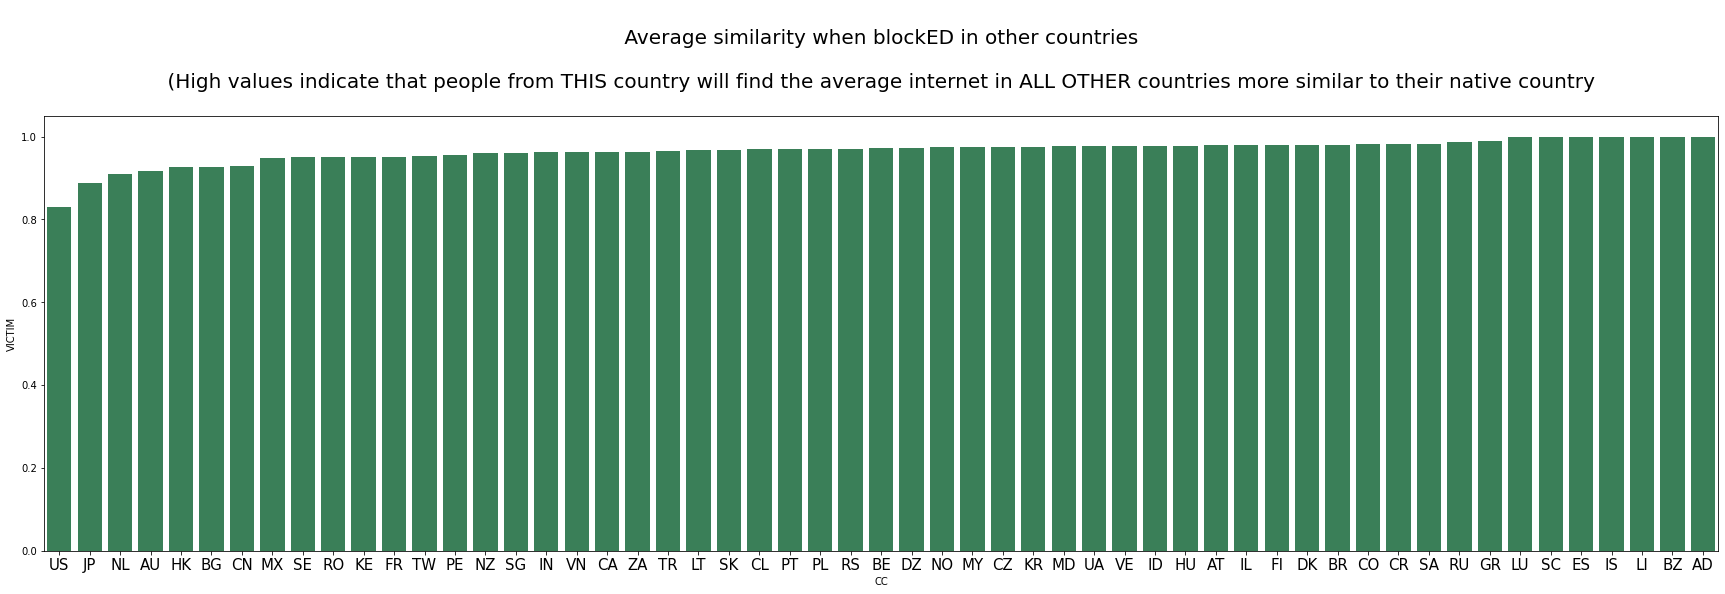

In [ ]:
#VICTIM GRAPH
plt.figure(figsize=(30,8))
values = Cumulative['VICTIM'].sort_values() 
idx = Cumulative['VICTIM'].sort_values().index 
plt.title('\n Average similarity when blockED in other countries \n \n (High values indicate that people from THIS country will find the average internet in ALL OTHER countries more similar to their native country \n', size= 20)

ax = sns.barplot(x=idx, y=values, color = 'seagreen') 
plt.xticks(size=15)
plt.show()

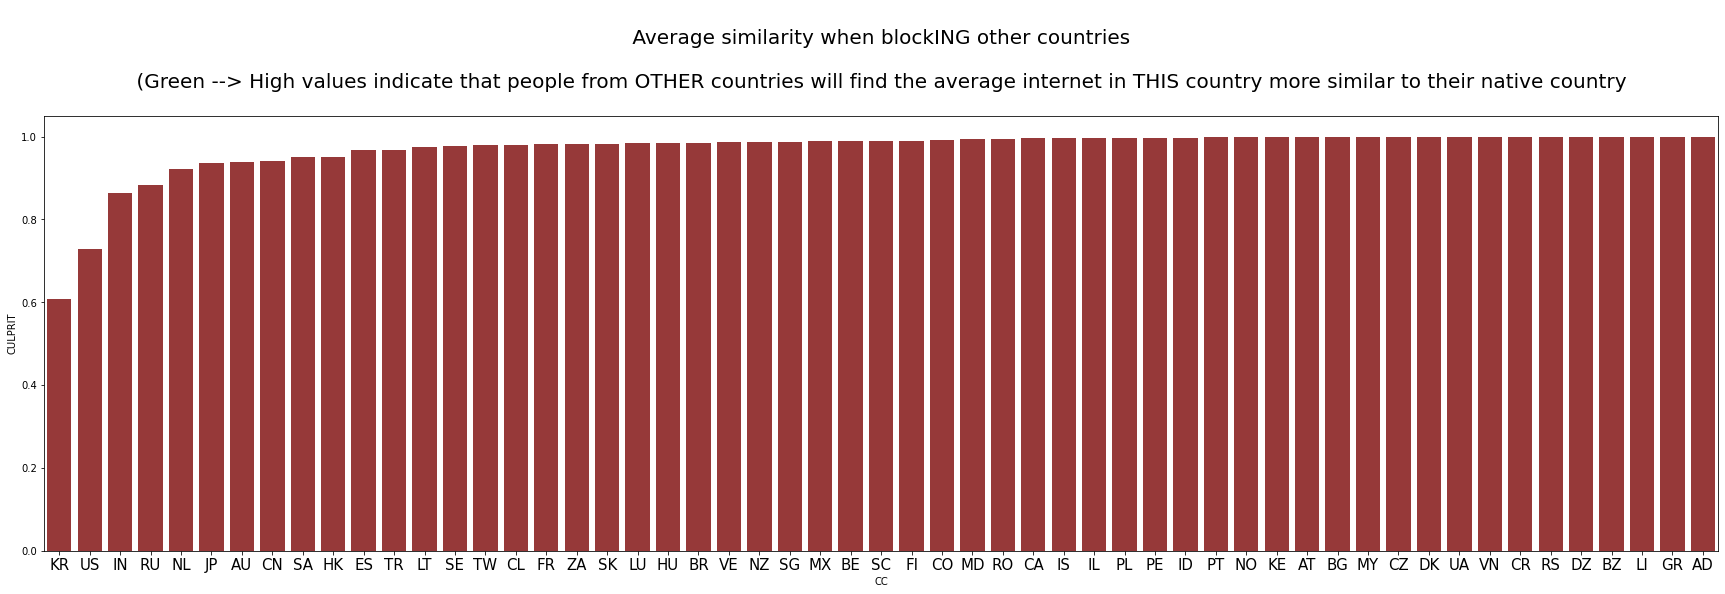

In [ ]:
#CULPRIT GRAPH
plt.figure(figsize=(30,8))
values = Cumulative['CULPRIT'].sort_values() 
idx = Cumulative['CULPRIT'].sort_values().index 
plt.title('\n Average similarity when blockING other countries \n \n (Green --> High values indicate that people from OTHER countries will find the average internet in THIS country more similar to their native country \n', size= 20)
plt.xticks(size=15)
ax = sns.barplot(x=idx, y=values,color ='brown') 
plt.show()

In [ ]:
# ABSOLUTE DIFFERENCE GRAPH
# DIFFERENCE = VICTIM - CULPRIT

plt.figure(figsize=(30,8))
values = Cumulative['AbsDiff'].sort_values() 
idx = Cumulative['AbsDiff'].sort_values().index 
plt.title('\n Absolute asymmetry values \n\n Absolute ASYMMETRY = Absolute[Average Similarity(When BlockED In Other Countries) - Average Similarity(When BlockING Other Countries)]\n \n (Green --> Difference greater than global average \n \n', size= 20)
plt.xticks(size=15)
ax = sns.barplot(x=idx, y=values) 

for bar in ax.patches:
    if bar.get_height() >= np.mean(values):
        bar.set_color('green')    
    else:
        bar.set_color('red')

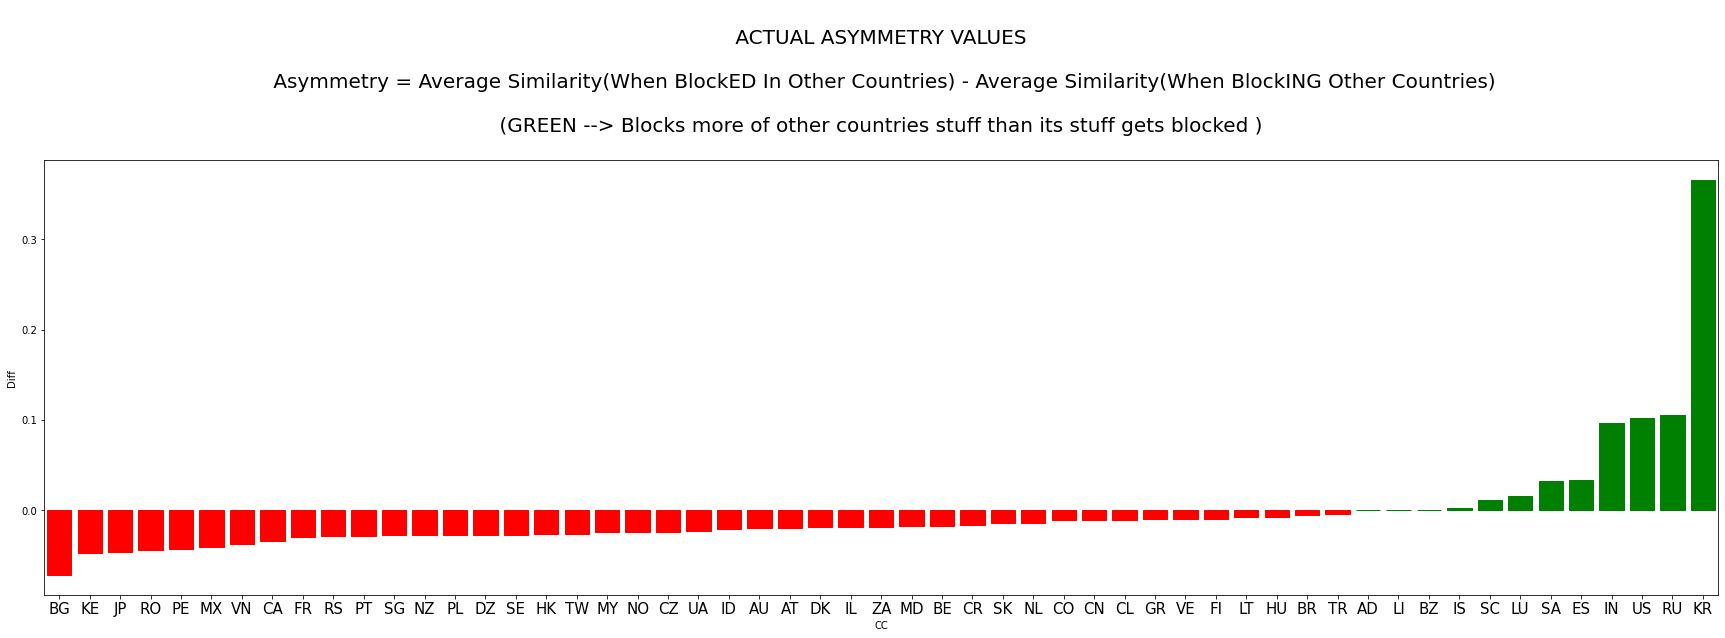

In [ ]:
#DIFFERENCE GRAPH
# DIFFERENCE = VICTIM - CULPRIT

plt.figure(figsize=(30,8))
values = Cumulative['Diff'].sort_values() 
idx = Cumulative['Diff'].sort_values().index 
plt.title('\n ACTUAL ASYMMETRY VALUES \n\n Asymmetry = Average Similarity(When BlockED In Other Countries) - Average Similarity(When BlockING Other Countries)\n \n (GREEN --> Blocks more of other countries stuff than its stuff gets blocked ) \n', size= 20)
plt.xticks(size=15)
ax = sns.barplot(x=idx, y=values) 

for bar in ax.patches:
    if bar.get_height() >= 0:
        bar.set_color('green')    
    else:
        bar.set_color('red')

### Country Specific Analysis

In [ ]:
def cc_analysis(cc):

  """Creates visualization for a country (cc) to show 
  its similarities with countries whose top websites it's blocking and where it's own top websites are being blocked"""

  ccasX = ImpactDF[(ImpactDF["country_code_alpha2_X"].str.contains(cc, na=False)) ][['country_code_alpha2_Y','X2Y_Similarity']].rename(columns={'country_code_alpha2_Y':'destination(Y)','X2Y_Similarity':'toYsim'})
  #print(len(ccasX))
  ccasY = ImpactDF[(ImpactDF["country_code_alpha2_Y"].str.contains(cc, na=False)) ][['country_code_alpha2_X','Y2X_Similarity']].rename(columns={'country_code_alpha2_X':'destination(Y)','Y2X_Similarity':'toYsim'})
  #print(len(ccasY))

  ccDFX = pd.concat([ccasX,ccasY],axis=0)
  ccDFX = ccDFX.sort_values(by='toYsim')

  plt.figure(figsize=(30,8))
  plt.title("Similarity of countries to " + cc + " when they block its top websites \n OR \n The internet for a person from " + cc + " when they visit these countries" , size= 20)
  plt.xticks(size=12)
  Xax = sns.barplot(x='destination(Y)', y='toYsim', data = ccDFX)

  for bar in Xax.patches:
    if bar.get_height() >= 0.9:
        bar.set_color('green')
    elif bar.get_height() <= 0.6:   
      bar.set_color('red')
    else:
        bar.set_color('slategrey')  

  ccasYY = ImpactDF[(ImpactDF["country_code_alpha2_Y"].str.contains(cc, na=False)) ][['country_code_alpha2_X','X2Y_Similarity']].rename(columns={'country_code_alpha2_X':'source(X)','X2Y_Similarity':'fromXsim'})
  #print(len(ccasYY))

  ccasXX = ImpactDF[(ImpactDF["country_code_alpha2_X"].str.contains(cc, na=False)) ][['country_code_alpha2_Y','Y2X_Similarity']].rename(columns={'country_code_alpha2_Y':'source(X)','Y2X_Similarity':'fromXsim'})
  #print(len(ccasXX))

  ccDFY = pd.concat([ccasYY,ccasXX],axis=0)
  ccDFY = ccDFY.sort_values(by='fromXsim')
  
  plt.figure(figsize=(30,8))
  plt.title( cc + "'s similarity to countries whose top websites it is blocking \n OR \n The internet for a person from these countries when they vist " + cc , size= 20)
  plt.xticks(size=12)
  Yax = sns.barplot(x='source(X)', y='fromXsim', data = ccDFY)
  
  for bar in Yax.patches:
    if bar.get_height() >= 0.9:
        bar.set_color('green')
    elif bar.get_height() <= 0.6:   
      bar.set_color('red')
    else:
        bar.set_color('slategrey')

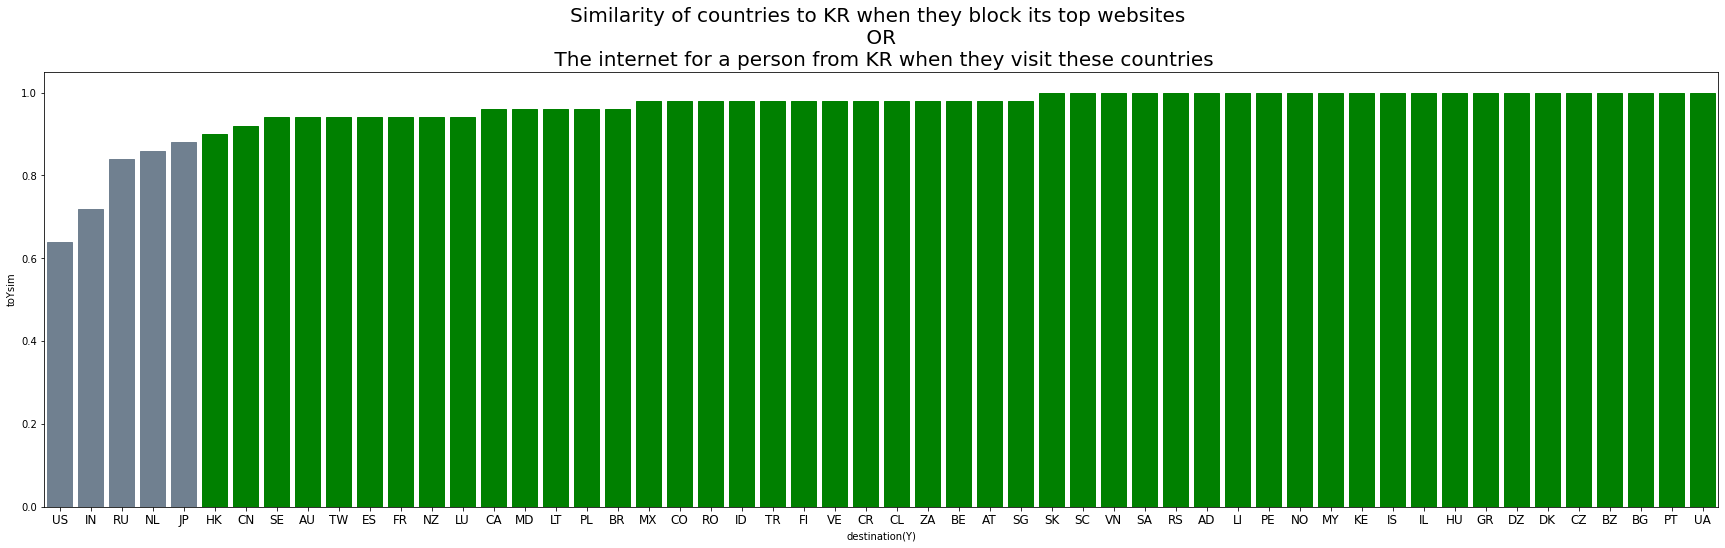

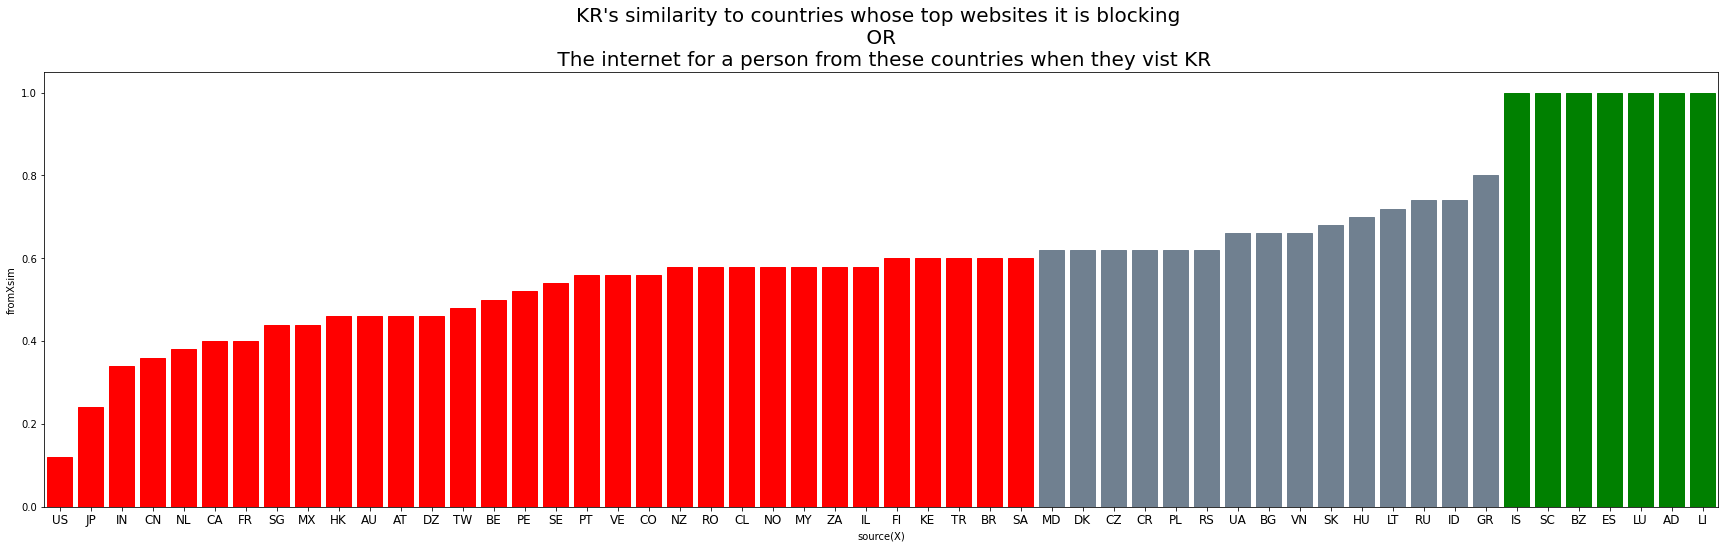

In [ ]:
cc_analysis('KR')

In [ ]:
cc_analysis('RU')

In [ ]:
cc_analysis('IN')

In [ ]:
cc_analysis('US')

In [ ]:
cc_analysis('JP')

In [ ]:
cc_analysis('BG')

## 4.4 Category level Asymmetry Viz

-- Analyzing category overlap in directed blocking

### Function Setup

In [ ]:
def BlockedCategories(country_code):
  
  """
  Returns a set of Blocked categories in the Country
  Parameter: Country Code
  """

  # Country Specific blocked sites list
  CC_blocked_cat = iclabClean1 [ (iclabClean1['country']==country_code) &(iclabClean1['censored_updated']==True)] [['site','category']]
  CC_blocked_cat = CC_blocked_cat.groupby('category').count().sort_values(by='site',ascending=False)
  CC_blocked_cat['site'] = CC_blocked_cat*100/np.sum(CC_blocked_cat['site'])
  CC_blocked_cat = CC_blocked_cat.iloc[:9,:].reset_index()

  otherVals  = 100-np.sum(CC_blocked_cat['site'])
  lastRow ={'category':'REMAINING','site':otherVals}
  CC_blocked_cat = CC_blocked_cat.append(lastRow, ignore_index=True)

  CC_blocked_cat = CC_blocked_cat.sort_values(by='site',ascending=True)

  return CC_blocked_cat

In [ ]:
def TopCategories(country_code):
  
  """Returns Categories of Top Websites in the country """

  #Scraping Top Sites list from Alexa for country 
  url = "https://www.alexa.com/topsites/countries/" + country_code
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  div = soup.find_all('div', class_='td DescriptionCell')

  CC_top_list = []
  for link in div:
    name = link.find('a')
    CC_top_list.append((name.get_text('siteinfo')).lower())
  topSites = set(CC_top_list) #Top sites in country 

  topSites  = pd.DataFrame(list(topSites)).rename(columns={0:'site'})
  AllCats = iclabClean1 [(iclabClean1['country']==country_code)] [['site','category']]
  topSiteCat = pd.merge(topSites,AllCats,on='site', how='left').groupby('site').first().replace(np.nan,'Undefined').reset_index()
  topSiteCat = topSiteCat.groupby('category').count().sort_values(by='site',ascending=False)
  topSiteCat['site'] = topSiteCat*100/np.sum(topSiteCat['site'])

  topSiteCat = topSiteCat.iloc[:9,:].reset_index()
  otherVals  = 100 - np.sum(topSiteCat['site'])
  lastRow = {'category':'REMAINING','site':otherVals}
  topSiteCat = topSiteCat.append(lastRow, ignore_index=True)
  topSiteCat = topSiteCat.sort_values(by='site',ascending=True)

  return topSiteCat

In [ ]:
def blocked_pie(cc):
  labels = BlockedCategories(cc)['category']
  sizes = BlockedCategories(cc)['site']
  explode = list(np.zeros(len(labels)-3))
  explode.extend([0.1,0.1,0.1])   # "explode" the top 3 slices
  fig1, ax1 = plt.subplots(figsize=(9,9))
  wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', startangle=180, textprops=dict(color="black"))
  ax1.axis('equal')
  #ax1.legend(wedges, labels, title="Blocked Categories", loc="center left",bbox_to_anchor=(1.15,.5,0,1))
  plt.setp(autotexts, size=14, weight="bold")
  ax.set_title("Top blocked Categories in country")
  plt.show()

In [ ]:
def top_pie(cc):
  labels = TopCategories(cc)['category']
  sizes = TopCategories(cc)['site']
  explode = list(np.zeros(len(labels)-3))
  explode.extend([0.1,0.1,0.1])   # "explode" the top 3 slices
  fig1, ax1 = plt.subplots(figsize=(9,9))
  wedges, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', startangle=180, textprops=dict(color="black"))
  ax1.axis('equal')
  #ax1.legend(wedges, labels, title="Top Categories", loc="center left",bbox_to_anchor=(1.15,.5,0,1))
  plt.setp(autotexts, size=14, weight="bold")
  ax.set_title("Top visited Categories in country")
  plt.show()

### Pie Charts

#### CN

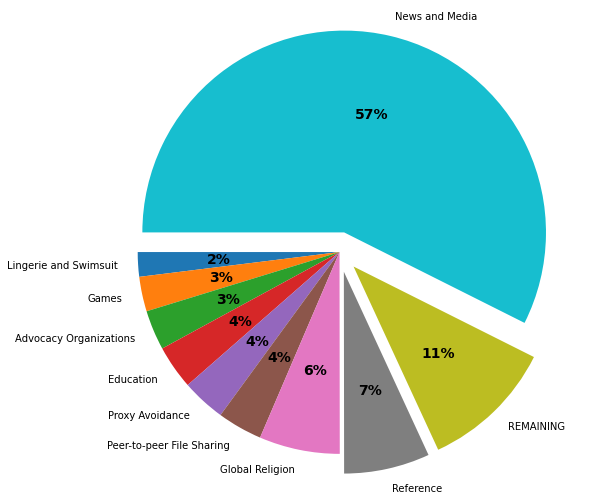

In [ ]:
blocked_pie('CN')

In [ ]:
top_pie(cc)

#### KR

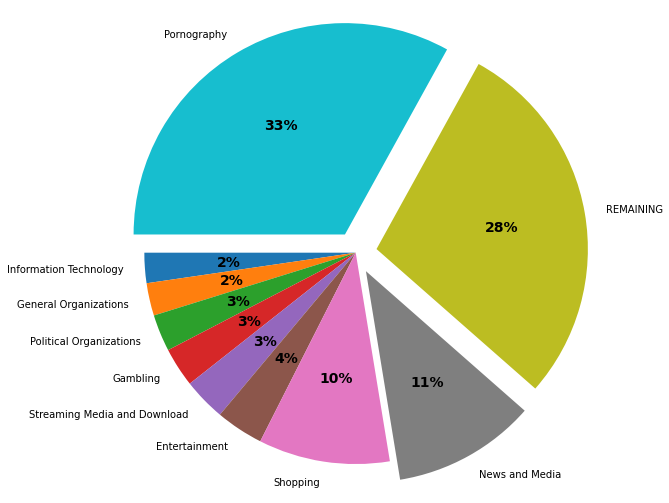

In [ ]:
blocked_pie('KR')

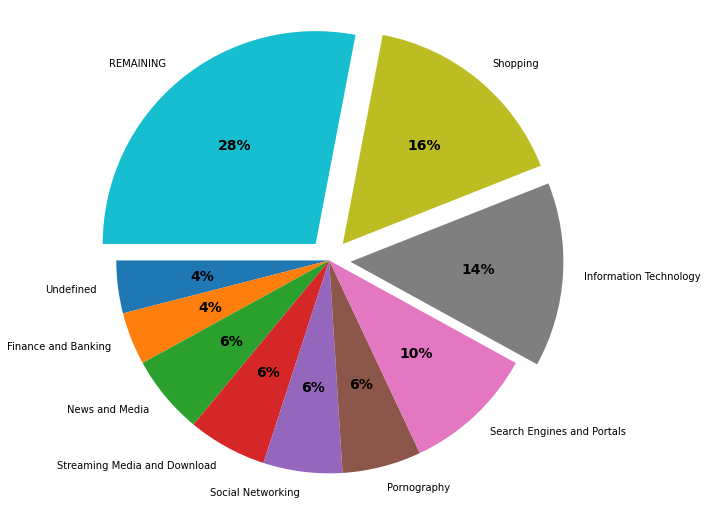

In [ ]:
top_pie('US')

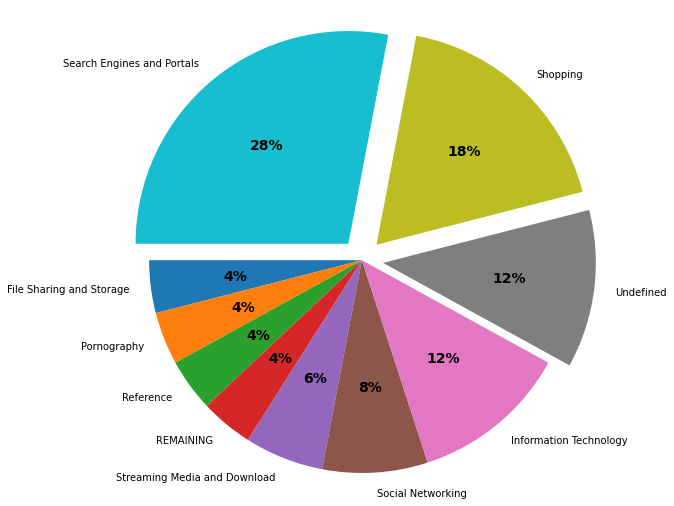

In [ ]:
top_pie('JP')

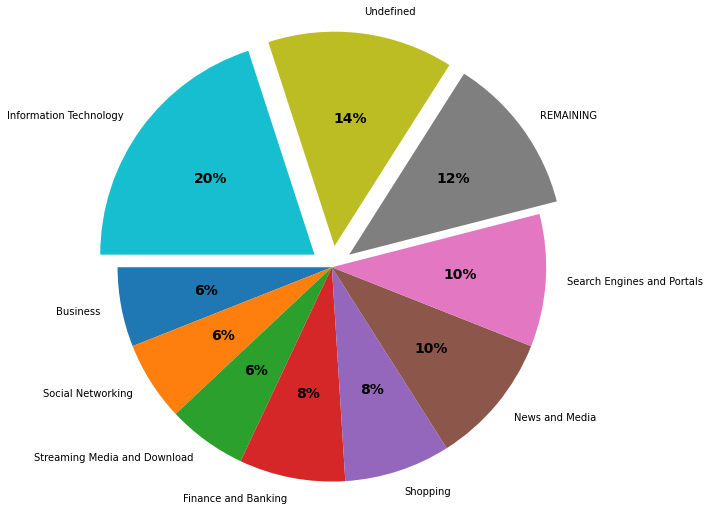

In [ ]:
top_pie('IN')

#### US

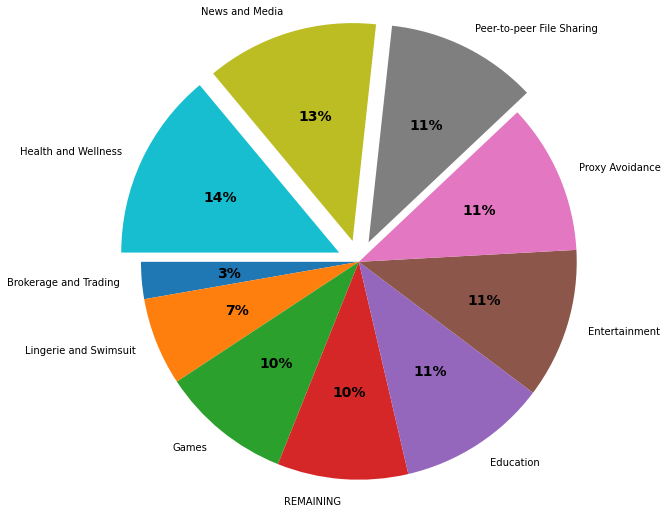

In [ ]:
blocked_pie('US')

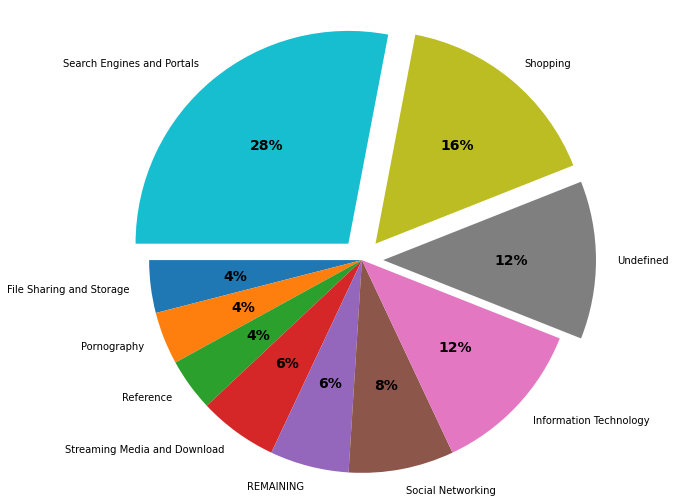

In [ ]:
top_pie('JP')

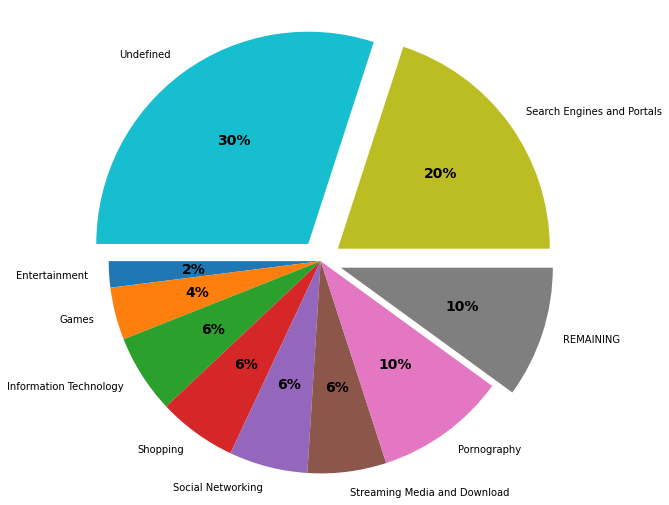

In [ ]:
top_pie('NL')

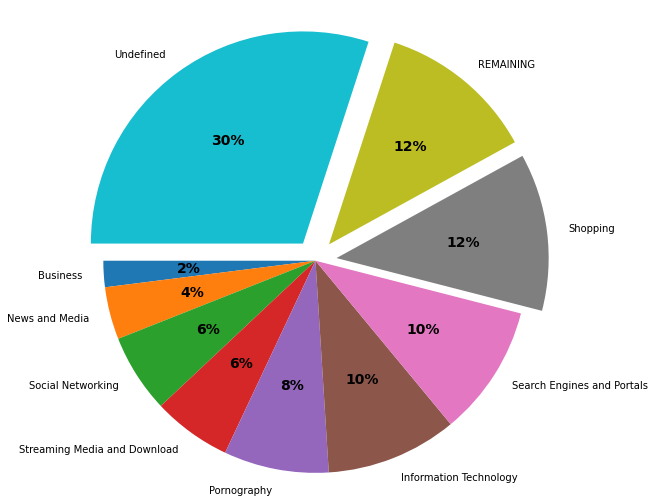

In [ ]:
top_pie('CA')

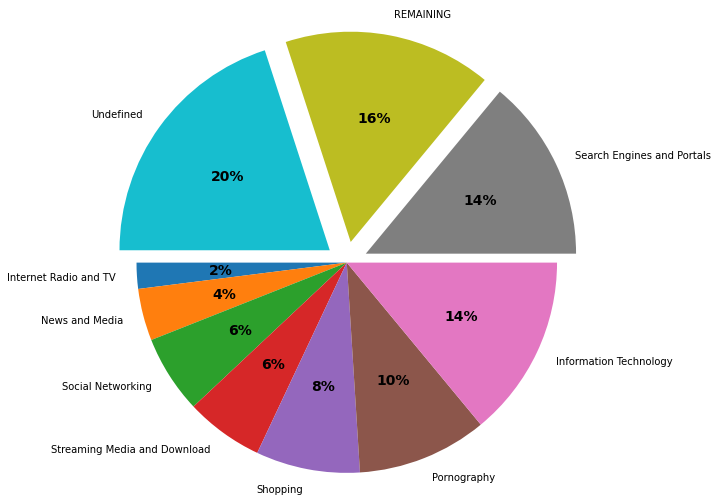

In [ ]:
top_pie('FR')

### Intersection Plots

In [ ]:
blockKR = BlockedCategories('KR').rename(columns={'site':'KR'})
blockKR

,category,KR
8,Information Technology,2.311941
7,General Organizations,2.490954
6,Political Organizations,2.822320
5,Gambling,3.008951
4,Streaming Media and Download,3.264140
3,Entertainment,3.645020
2,Shopping,10.043801
1,News and Media,10.938869
9,REMAINING,28.447915
0,Pornography,33.026090


In [ ]:
topUS = TopCategories('US').rename(columns={'site':'US'})

In [ ]:
topJP = TopCategories('JP').rename(columns={'site':'JP'})

In [ ]:
topIN = TopCategories('IN').rename(columns={'site':'IN'})

In [ ]:
from upsetplot import generate_data
example = generate_data(aggregated=True)
example

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

In [ ]:
df1 = pd.merge(blockKR,topUS, on='category', how ='outer')
df2 = pd.merge(df1,topIN, on='category', how ='outer')
df3 = pd.merge(df2,topJP, on='category', how ='outer')

In [ ]:
# from upsetplot import plot
# plot(df3)
df3

,category,KR,US,IN,JP
0,Information Technology,2.311941,14.0,20.0,12.0
1,General Organizations,2.490954,NaN,NaN,NaN
2,Political Organizations,2.822320,NaN,NaN,NaN
3,Gambling,3.008951,NaN,NaN,NaN
4,Streaming Media and Download,3.264140,6.0,6.0,6.0
5,Entertainment,3.645020,NaN,NaN,NaN
6,Shopping,10.043801,16.0,8.0,18.0
7,News and Media,10.938869,6.0,10.0,NaN
8,REMAINING,28.447915,28.0,12.0,4.0
9,Pornography,33.026090,6.0,NaN,4.0


## 4.5 Output Files

--JSON and CSV

### JSON output

In [ ]:
impact_pairs_of_similarities = {}
for _, row in ImpactDF.iterrows():
    countryX = row['country_code_alpha3_X']
    countryY = row['country_code_alpha3_Y']
    country_pair = countryX +'->'+ countryY
    impact_pairs_of_similarities[country_pair] = row.to_dict()

In [ ]:
impact_json = json.dumps(impact_pairs_of_similarities)

In [ ]:
impact_json

'{"AND->AUT": {"pair": ["AD", "AT"], "country_code_alpha2_X": "AD", "country_code_alpha2_Y": "AT", "X2Y_Similarity": 1.0, "Y2X_Similarity": 1.0, "Edge_Asymmetry": 0.0, "Average_Similarity": 1.0, "country_code_alpha3_X": "AND", "country_code_alpha3_Y": "AUT"}, "AND->BEL": {"pair": ["AD", "BE"], "country_code_alpha2_X": "AD", "country_code_alpha2_Y": "BE", "X2Y_Similarity": 1.0, "Y2X_Similarity": 1.0, "Edge_Asymmetry": 0.0, "Average_Similarity": 1.0, "country_code_alpha3_X": "AND", "country_code_alpha3_Y": "BEL"}, "AND->BRA": {"pair": ["AD", "BR"], "country_code_alpha2_X": "AD", "country_code_alpha2_Y": "BR", "X2Y_Similarity": 1.0, "Y2X_Similarity": 1.0, "Edge_Asymmetry": 0.0, "Average_Similarity": 1.0, "country_code_alpha3_X": "AND", "country_code_alpha3_Y": "BRA"}, "AND->CAN": {"pair": ["AD", "CA"], "country_code_alpha2_X": "AD", "country_code_alpha2_Y": "CA", "X2Y_Similarity": 1.0, "Y2X_Similarity": 1.0, "Edge_Asymmetry": 0.0, "Average_Similarity": 1.0, "country_code_alpha3_X": "AND",

In [ ]:
with open('impact_json', 'w') as outfile:
    json.dump(impact_json, outfile)

### CSV Output

In [ ]:
ImpactDF.to_csv('NewProxy.csv')

In [ ]:
import pandas as pd
from sklearn.datasets import load_boston
from matplotlib import pyplot as plt
from upsetplot import UpSet

# Load the dataset into a DataFrame
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)


In [ ]:
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [ ]:

# Get five features most correlated with median house value
correls = boston_df.corrwith(pd.Series(boston.target),
                             method='spearman').sort_values()
top_features = correls.index[-5:]


In [ ]:
top_features 


Index(['CHAS', 'B', 'ZN', 'DIS', 'RM'], dtype='object')

In [ ]:

# Get a binary indicator of whether each top feature is above average
boston_above_avg = boston_df > boston_df.median(axis=0)
boston_above_avg = boston_above_avg[top_features]
boston_above_avg = boston_above_avg.rename(columns=lambda x: x + '>')


In [ ]:

# Make this indicator mask an index of boston_df
boston_df = pd.concat([boston_df, boston_above_avg],
                      axis=1)
boston_df = boston_df.set_index(list(boston_above_avg.columns))


In [ ]:
boston_df

CRIM    ZN  INDUS  ...  PTRATIO       B  LSTAT
CHAS> B>   ZN>   DIS>  RM>                          ...                        
False True True  True  True   0.00632  18.0   2.31  ...     15.3  396.90   4.98
           False True  True   0.02731   0.0   7.07  ...     17.8  396.90   9.14
                       True   0.02729   0.0   7.07  ...     17.8  392.83   4.03
                       True   0.03237   0.0   2.18  ...     18.7  394.63   2.94
                       True   0.06905   0.0   2.18  ...     18.7  396.90   5.33
...                               ...   ...    ...  ...      ...     ...    ...
                 False True   0.06263   0.0  11.93  ...     21.0  391.99   9.67
                       False  0.04527   0.0  11.93  ...     21.0  396.90   9.08
                       True   0.06076   0.0  11.93  ...     21.0  396.90   5.64
                       True   0.10959   0.0  11.93  ...     21.0  393.45   6.48
                       False  0.04741   0.0  11.93  ...     21.0  396.90   7.88

[506 rows x 13 columns]

In [ ]:

# Also give us access to the target (median house value)
boston_df = boston_df.assign(median_value=boston.target)


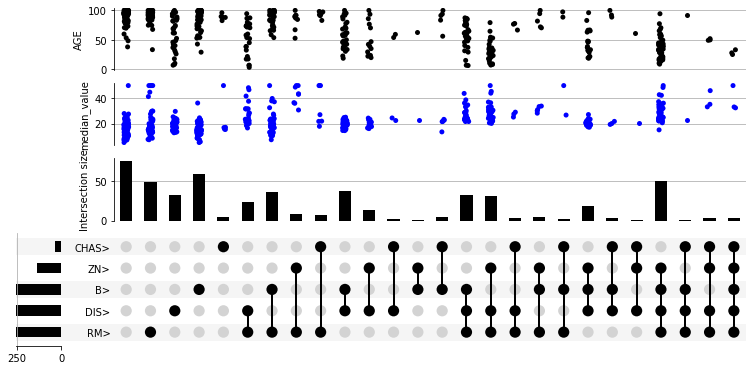

In [ ]:

# UpSet plot it!
upset = UpSet(boston_df, subset_size='count', intersection_plot_elements=3)
upset.add_catplot(value='median_value', kind='strip', color='blue')
upset.add_catplot(value='AGE', kind='strip', color='black')
upset.plot()
plt.show()